# Preparation - models:

## ResNet50:
* ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.
* While the original Resnet had 34 layers and used 2-layer blocks, other advanced variants such as the Resnet50 made the use of 3-layer bottleneck blocks to ensure improved accuracy and lesser training time.
example of 2-layer bottlneck block:    

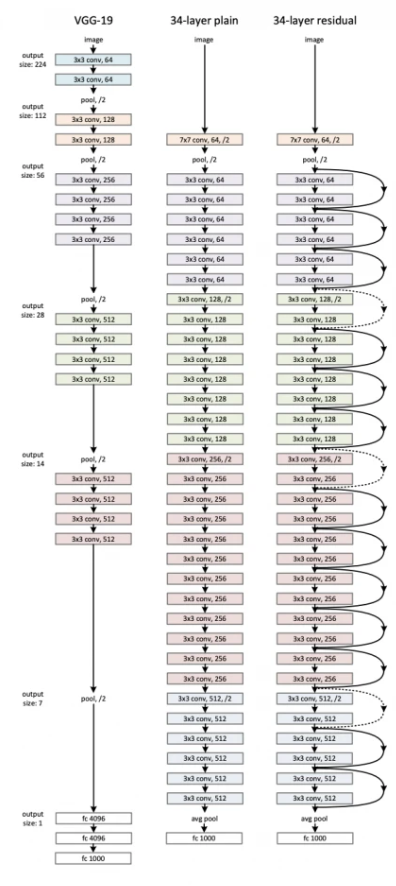
## EfficientNet-B3:
* 10,3646 million weights, IRC means there is inverted residual connection.
* achieve both higher accuracy and better efficiency over existing CNNs on ImageNet
illustrate EfficientNet-B3:    

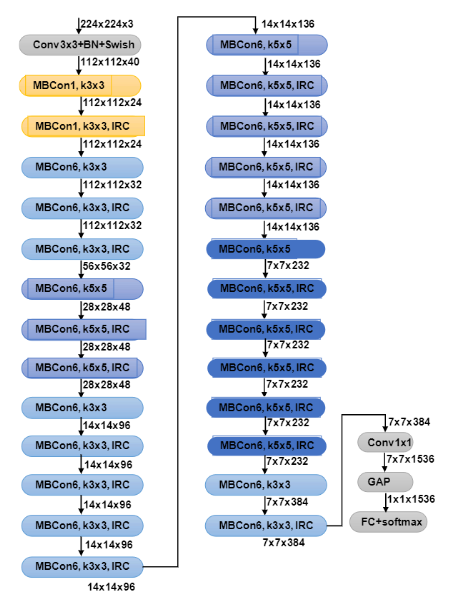

## Inception-V4:
* more uniform simplified architecture and more inception modules than Inception-v3.
* pure Inception variant without any residual connections. It can be trained without partitioning the replicas, with memory optimization to backpropagation.

illustrate Inception-V4:   

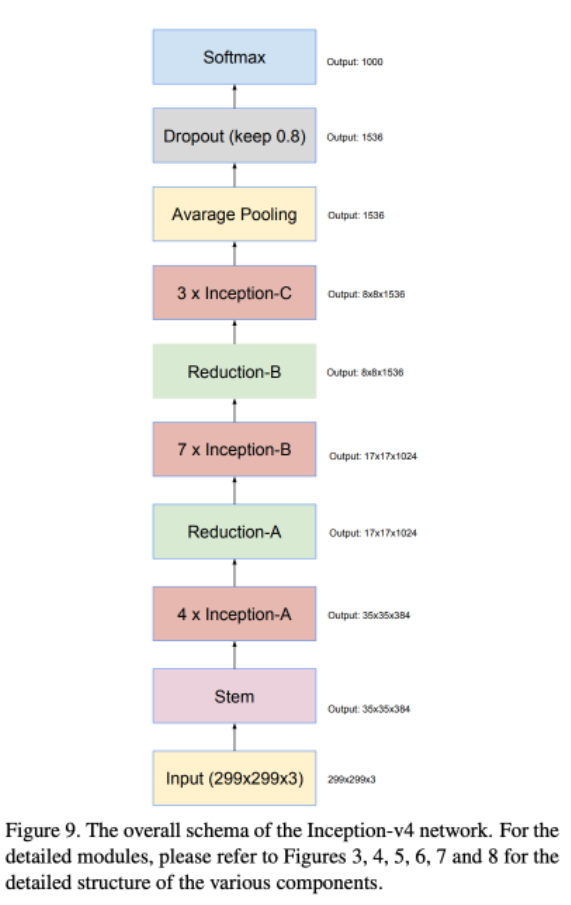

## MobileNetV3:
* semantic segmentation based on the idea of pooling as used Squeeze and Excitation
illustrate MobileNetV3:    

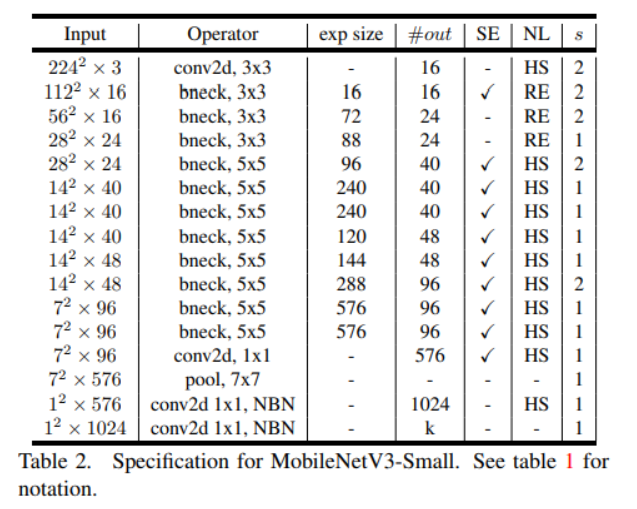

# Imports

In [ ]:
!pip install torchmetrics timm
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import seaborn as sns  
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, models, transforms
import torch
from matplotlib import pyplot as plt
import os
from cv2 import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torchmetrics 
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.optim import AdamW,Adam # optmizers
import time
from tqdm import tqdm

%config Completer.use_jedi = False

In [ ]:
data_path = "../input/224-224-cervical-cancer-screening/kaggle/train/train"
images  =  [glob.glob(os.path.join(data_path, d, "*.*")) for d in os.listdir(data_path)]
train_paths = np.hstack(images)
# Additional data
extra_1 = "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_1_v2"
extra_2 = "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_2_v2"
extra_3 = "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_3_v2"
images1  =  [glob.glob(os.path.join(extra_1, d, "*.*")) for d in os.listdir(extra_1)]
images2  =  [glob.glob(os.path.join(extra_2, d, "*.*")) for d in os.listdir(extra_2)]
images3  =  [glob.glob(os.path.join(extra_3, d, "*.*")) for d in os.listdir(extra_3)]
train_paths = np.append(train_paths, np.hstack(images1))
train_paths = np.append(train_paths, np.hstack(images2))
train_paths = np.append(train_paths, np.hstack(images3))

print(f'In this train set we have got a total of {len(train_paths)}')
N_EPOCHS = 5
OUTPUT_PATH = './'
BATCH_SIZE = 10
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device(device)
cpu = torch.device('cpu')

# Preparation - data:
* multiclass classification problem where 3 classes are:
    1. Type_1
    2. Type_2
    3. Type_3

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=80)
columns = 3
rows = 1
img_type1 = plt.imread('../input/224-224-cervical-cancer-screening/kaggle/train/train/Type_1/0.jpg')
fig.add_subplot(rows, columns, 1)
plt.title("Type1")
plt.axis('off')
plt.imshow(img_type1)

img_type2 = plt.imread('../input/224-224-cervical-cancer-screening/kaggle/train/train/Type_2/1.jpg')
fig.add_subplot(rows, columns, 2)
plt.title("Type2")
plt.axis('off')
plt.imshow(img_type2)

img_type3 = plt.imread('../input/224-224-cervical-cancer-screening/kaggle/train/train/Type_3/1000.jpg')
fig.add_subplot(rows, columns, 3)
plt.title("Type3")
plt.axis('off')
plt.imshow(img_type3)



In [ ]:
class MyDataset(Dataset):
    
    def __init__(self, paths, transform=None, train=True, size=224):
        self.paths = paths
        self.transform = transform
        self.train = train
        self.size = size
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        p = self.paths[idx]
        label = p.split("/")[-2].split("_")[-1]
        image = cv2.imread(p)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        return image, int(label) - 1 # label count starts from zero not 1 
# here we are using dataframe
class CancerDataset(Dataset):
    def __init__(self, df, x_col = "image", y_col = "target", augmentations = None):
        self.df = df
        self.features = df[x_col] # scale (greyscale) only features. do not scale target
        self.targets = df[y_col]
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.features[idx].float()
        label = self.targets[idx]
        #swap [224,224,3]---TO---> [3,224,224]
        image = image.permute(2, 0,1)
        if self.augmentations is not None:
            image = np.array(image)
            augmented = self.augmentations(image=image)  

            image = torch.from_numpy(augmented['image'])
            image = image.float()
            return image, label

        return image, label

def norm(img):
    img-=img.min()
    img=img/img.max()
    return img

In [ ]:
transform = A.Compose([
    A.OneOf([A.Blur(blur_limit=3), A.MotionBlur(blur_limit=3)]),
    A.GaussNoise(), A.Sharpen(),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT),])    

dataset = MyDataset(train_paths, transform, train=True, size=224)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
df =  pd.DataFrame(columns=["image","target"])
iter_loader = iter(train_loader)
for x,y in iter_loader:
    for i,(row,t) in enumerate(zip(x,y)):
        df = df.append({"image":row, "target": t.item()}, ignore_index = True)
df.head()

In [ ]:
#Note- 0-type1, 1-type2, 2-type3
#plotting the graph  
sns.countplot(x='target', data=df, palette='pastel')  
plt.show()  

* We can clearly see that in our train dataframe type_2 (target=1) is the most common one.

# Split- train & validation

In [ ]:
## random split
train_df, valid_df = train_test_split(df, test_size=0.3, random_state= 42)
train_df.reset_index(inplace = True)
valid_df.reset_index(inplace = True)

# create dataset for validation & train
train_dataset = CancerDataset(train_df, augmentations = transform) 
valid_dataset = CancerDataset(valid_df)

# create dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        bce = self.cross_entropy_loss(inputs, targets)
        pt = torch.exp(-bce)
        loss = bce * self.alpha * (torch.pow((1 - pt), self.gamma))
        return loss

# in general alpha should be decreasing and gamma should be increasing.
class Model(nn.Module):
    def __init__(self, model_name, pretrained = True, num_classes = 3):
        super().__init__()
        self.model_name = model_name
        self.cnn = timm.create_model(self.model_name, pretrained = pretrained, num_classes = num_classes)

    def forward(self, x):
        x = self.cnn(x)
        return x
    
    def train_mode(self):
        self.best_loss = np.inf
        self.best_epoch = 0
        self.best_acc = 0
        self.train_loss_history = []
        self.train_acc_history = []
        
    def valid_mode(self):
        self.valid_loss_history = []
        self.valid_acc_history = []
        
def train_one_epoch(train_loader, model, criterion, optimizer, device):
    # switch to train mode
    model.train()   
    size = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss, correct = 0, 0
    ################################# train #################################
    for batch, (x, y) in enumerate(train_loader):
        start = time.time()
        device = torch.device(device)
        x, y = x.to(device), y.to(device)  
        # compute predictions and loss
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y.long().squeeze()) 
        current = batch * len(x)
        # Backpropagation: only in train function, not done in validation function
        loss.backward()
        optimizer.step()
        # sum correct predictions
        y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
        correct += (y_pred == y_true).type(torch.float).sum().item()
        end = time.time()
        time_delta = np.round(end - start, 3)
        # log
        loss, current = np.round(loss.item(), 5), batch * len(x)
    # metrics: calculate accuracy and loss for epoch (all batches)
    correct /= size # epoch accuracy
    loss /= num_batches # epoch loss
    print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")
    model.train_loss_history.append(loss)
    model.train_acc_history.append(correct)
    return loss, correct
    
def valid_one_epoch(valid_loader, model, criterion, device):
    model.eval()
    size = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    loss, correct = 0, 0
    ################################# validation #################################
    with torch.no_grad(): # disable gradients
        for batch, (x, y) in enumerate(valid_loader):
            start = time.time()
            device = torch.device(device)
            x, y = x.to(device), y.to(device)
            # compute predictions and loss
            pred = model(x)
            loss = criterion(pred, y.long().squeeze()) 
            current = batch * len(x)
            # sum correct predictions
            y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
            correct += (y_pred == y_true).type(torch.float).sum().item()
            end = time.time()
            time_delta = np.round(end - start, 3)
            # log
            loss, current = np.round(loss.item(), 5), batch * len(x)
    # metrics: calculate accuracy and loss for epoch (all batches)
    correct /= size # epoch accuracy
    loss /= num_batches # epoch loss
    model.valid_loss_history.append(loss)
    model.valid_acc_history.append(correct)
    print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")
    return loss, correct

def train_valid(train_loader,valid_loader, model, device):
    # Create optimizer & loss
    model.optimizer = Adam(model.parameters(),lr=1e-4)
    loss_fn = FocalLoss()
    
    print('\n ******************************* Using backbone: ', model.model_name, " ******************************* \n")
    print('Starting Training...\n')
    start_train_time = time.time()
    model.train_mode()
    model.valid_mode()
    for epoch in tqdm(range(0, N_EPOCHS)):
        print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
        start_epoch_time = time.time()
        # train
        train_one_epoch(train_loader, model, loss_fn, model.optimizer, device)
        # validation
        valid_loss, valid_acc = valid_one_epoch(valid_loader, model, loss_fn, device)
        # save validation loss if it was improved (reduced) & validation accuracy if it was improved (increased)
        if valid_loss < model.best_loss and valid_acc > model.best_acc:
            model.best_epoch = epoch + 1
            model.best_loss = valid_loss
            model.best_acc = valid_acc
            # save the model's weights and biases   
            torch.save(model.state_dict(), OUTPUT_PATH + f"{model.model_name}_ep{model.best_epoch}.pth")        
            torch.save(model.state_dict(), OUTPUT_PATH + f"{model.model_name}_ep{model.best_epoch}.pth")

        end_epoch_time = time.time()
        time_delta = np.round(end_epoch_time - start_epoch_time, 3)
        print("\n\nEpoch Elapsed Time: {} s".format(time_delta))

    end_train_time = time.time()
    print("\n\nTotal Elapsed Time: {} min".format(np.round((end_train_time - start_train_time)/60, 3)))
    print("Done!")

def plot_results(model):
    fig = plt.figure(figsize = (18, 8))
    fig.suptitle(f"{model.model_name} Training Results", fontsize = 18)

    space = np.arange(1, N_EPOCHS + 1, 1)
    if N_EPOCHS <= 20:
        x_ticks = np.arange(1, N_EPOCHS + 1, 1)
    else:
        x_ticks = np.arange(1, N_EPOCHS + 1, int(N_EPOCHS/20) + 1)

    # Loss plot
    ax1 = plt.subplot(1, 2, 1) 
    ax1.plot(space, model.train_loss_history, label='Training', color = 'black')
    ax1.plot(space, model.valid_loss_history, label='Validation', color = 'blue')
    plt.xticks(x_ticks)
    plt.axhline(0, linestyle = 'dashed', color = 'grey')
    plt.axvline(model.best_epoch, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(model.best_epoch))
    plt.title("Loss")
    ax1.legend(frameon=False);

    # Accuracy plot
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(space, model.train_acc_history, label='Training', color = 'black')
    ax2.plot(space, model.valid_acc_history, label='Validation', color = 'blue')
    plt.xticks(x_ticks)
    plt.axhline(0.99, linestyle = 'dashed', color = 'grey')
    plt.axvline(model.best_epoch, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(model.best_epoch))
    plt.title("Accuracy")
    ax2.legend(frameon=False);

# Train & Architectures

## MobileNetV3


In [ ]:
model_mobileNet = Model('mobilenetv3_large_100', pretrained = True, num_classes = 3)
model_mobileNet = model_mobileNet.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_mobileNet, device)
plot_results(model_mobileNet)

model_mobileNet = model_mobileNet.to(cpu)
gc.collect()
torch.cuda.empty_cache()

## ResNet50


In [ ]:
model_resNet50 = Model('resnet50', pretrained = True, num_classes = 3)
model_resNet50 = model_resNet50.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_resNet50, device)
plot_results(model_resNet50)

model_resNet50 = model_resNet50.to(cpu)
gc.collect()
torch.cuda.empty_cache()

## EfficentNet-B3

In [ ]:
model_efficientnet_b3 = Model('efficientnet_b3_pruned', pretrained = True, num_classes = 3)
model_efficientnet_b3 = model_efficientnet_b3.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_efficientnet_b3, device)
plot_results(model_efficientnet_b3)

model_efficientnet_b3 = model_efficientnet_b3.to(cpu)
gc.collect()
torch.cuda.empty_cache()

## Inception Net

In [ ]:
model_inception_v4 = Model('inception_v4', pretrained = True, num_classes = 3)
model_inception_v4 = model_inception_v4.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_inception_v4, device)
plot_results(model_inception_v4)

model_inception_v4 = model_inception_v4.to(cpu)
gc.collect()
torch.cuda.empty_cache()

# Confusion Matrix

In [ ]:
from sklearn.metrics import f1_score
#after train we want to do prediction for valdtaion data (in trainning mode) or test data (on test mode)
def predict(model,valid_dataloader,optimizer):
    Y_predict = []
    T = []
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch in valid_dataloader:
            optimizer.zero_grad()
            output = model(x_batch)
            for i in torch.argmax(output,1):
                Y_predict.append(i.item())
            for i in y_batch:
                T.append(i.item())
    return Y_predict, T

models = [model_mobileNet, 
               model_resNet50,
               model_efficientnet_b3, 
               model_inception_v4]
for model in tqdm(models):
    model.Y_pred,model.T =  predict(model, valid_dataloader,model.optimizer) 
    model.fscore = f1_score(model.Y_pred,model.T,average='macro')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for model, ax in tqdm(zip(models, axes.flatten())):
    model.cf_matrix = confusion_matrix(model.Y_pred,model.T)
    
    sns.heatmap(model.cf_matrix, annot=True, cmap='Blues',fmt='g',ax=ax)
    
    ax.title.set_text(f'{model.model_name}\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
plt.tight_layout()  
plt.show()

## Analyze Confusion metrics
* Precision: Appropriate when minimizing false positives is the focus.
* Recall: Appropriate when minimizing false negatives is the focus.
* Alone, neither precision or recall tells the whole story. We can have excellent precision with terrible recall, or alternately, terrible precision with excellent recall. F-measure provides a way to express both concerns with a single score. **the higher the F1 score the better**
    * Precision = Sum c in C TruePositives_c / Sum c in C (TruePositives_c + FalsePositives_c)
    * Recall = Sum c in C TruePositives_c / Sum c in C (TruePositives_c + FalseNegatives_c)
    * F-Measure = (2 * Precision * Recall) / (Precision + Recall)

* Additional metrics:
    * Specificity [true negative rate] : `TNR = TN/(TN+FP) `
    * Negative predictive value : `NPV = TN/(TN+FN) `
    * Fall out [false positive rate] : `FPR = FP/(FP+TN) `
    * False negative rate [true negative rate] : `FNR = FN/(TP+FN) `
    * False discovery rate [true negative rate] : `FDR = FP/(TP+FP) `

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# plot ROC curve and calculate AUC score
from sklearn.metrics import roc_curve, roc_auc_score
# Compute ROC curve and ROC area for each class

def plot_multiclass_roc(models):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    colors = ["aqua", "darkorange", "darkgreen"]
    for model, ax in tqdm(zip(models, axes.flatten())):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(np.array(model.T), np.array(model.Y_pred), pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(3):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 3
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ax.plot(fpr["macro"], tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4,)
        for i, color in zip(range(3), colors):
            ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)
            
        ax.plot([0, 1], [0, 1], "k--", lw=2)

        ax.axis([0.0, 1.0, 0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.title.set_text("Receiver Operating Characteristic (ROC) curve-" +model.model_name+
                          "\n(mean ROC = {0:0.4f})".format(sum(roc_auc.values()) / len(roc_auc),))
        
        ax.legend()
        
    plt.tight_layout()  
    plt.show()
    
plot_multiclass_roc(models)

* According to the graphs above the best performance was of the ResNet50 model

# Test & Submmision

In [ ]:
### for inference
class CancerInferenceDataset(Dataset):
    
    def __init__(self, df, augmentations = None): # for inference we only have the features dataframe
        self.df = df
        self.features = df['image'] 
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image =  self.features[idx].float()
        image = image.permute(2, 0,1)
        return image
    
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def inference(test_loader, model):
    model.eval()

    predictions = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)    

    # disable gradients for inference
    with torch.no_grad():
        for batch, X in enumerate(test_loader):
        
            ################################# inference #################################
            start = time.time()
            current = batch * len(X)

            X = X.to(device)

            # compute predictions
            pred = model(X)       
            # softmax
            y_pred = softmax(pred.detach().cpu().numpy()) # convert tensor to numpy and apply softmax 
#             y_pred = np.argmax(y_pred, axis = 1) # take the indice of the max value (higher probability: predicted class)

            # store results
            predictions.append(y_pred)

            # log
            end = time.time()
            time_delta = np.round(end - start, 5) 

    test_predictions = np.concatenate(predictions, axis = 0) # join sequence of arrays along axis 0
    return test_predictions


# Ensemble Model- 
An ensemble of several CNN models can significantly improve accuracy of our predictions, comparing to accuracy of any single model included into the ensemble.

<img src = "https://miro.medium.com/max/1400/1*nEyEGnC7N3nvbtpYwhwitg.png" height=600px width=600px>

In [ ]:
model_resneXt = Model('resnext50_32x4d', pretrained = True, num_classes = 3)
model_resneXt = model_resneXt.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_resneXt, device)
plot_results(model_resneXt)

model_resneXt = model_resneXt.to(cpu)
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(3 * 3, 3)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
    def train_mode(self):
        self.best_loss = np.inf
        self.best_epoch = 0
        self.best_acc = 0
        self.train_loss_history = []
        self.train_acc_history = []
        
    def valid_mode(self):
        self.valid_loss_history = []
        self.valid_acc_history = []
    
ensemble_model = EnsembleModel(model_resNet50, model_mobileNet, model_resneXt)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

In [ ]:
ensemble_model = ensemble_model.to(device)
ensemble_model.model_name = 'Ensemble Model'
train_valid(train_dataloader,valid_dataloader, ensemble_model, device)
plot_results(ensemble_model)

ensemble_model = ensemble_model.to(cpu)
gc.collect()
torch.cuda.empty_cache()

# Submmision

In [ ]:
test1 = os.listdir("../input/224-224-cervical-cancer-screening/kaggle/test/test")
test2 = os.listdir("../input/224-224-cervical-cancer-screening/kaggle/test_stg2")
df_test =  pd.DataFrame(columns=["image_index","image"])
print(f"Test files :  {len(test1)}. ---> {test1[:3]}")
for p in test1:
    image = cv2.imread("../input/224-224-cervical-cancer-screening/kaggle/test/test/"+p)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    df_test = df_test.append({"image_index": int(p.split(".")[0]),"image":torch.from_numpy(image).float()}, ignore_index = True)
print(f"Test files :  {len(test2)}. ---> {test2[:3]}")
for p in test2:
    image = cv2.imread("../input/224-224-cervical-cancer-screening/kaggle/test_stg2/"+p)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    df_test = df_test.append({"image_index": int(p.split(".")[0]),"image":torch.from_numpy(image).float()}, ignore_index = True)
df_test.head()


In [ ]:
df_test = df_test.sort_values(
    by="image_index",
    ascending=True)
df_test.head()

In [ ]:
test_dataset = CancerInferenceDataset(df_test) 
inference_dataloader = DataLoader(test_dataset,
                                  batch_size = BATCH_SIZE,
                                  shuffle = False)

N_EPOCHS = 15
model_ = ensemble_model.to(device) # move the model to GPU before constructing optimizers for it
train_valid(train_dataloader,valid_dataloader, model_, device)


In [ ]:
# run inference
predictions = inference(inference_dataloader, model_)

submission = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/sample_submission_stg2.csv")
submission.head() 

In [ ]:
with np.printoptions(precision=16, suppress=True):
    print(predictions)

In [ ]:
TYPE_1 = 0
TYPE_2 = 1
TYPE_3 = 2
row = 0
for i in predictions:
    submission.loc[row]= [submission.loc[row]['image_name'],np.float64(i[0]) ,np.float64(i[1]) ,np.float64( i[2])]
    row +=1
    
submission.to_csv(OUTPUT_PATH + 'submission.csv', index = False)
submission.head()

# TL;DR

**work process:**
1. I first arranged the input inside a dataframe for convenience (I used reduced data, mostly thanks to Ofri Harel).
2. I then split into train and validation and created a data loader for each of them when they are divided into 256 batches.
* After splitting the dataset it is important to reset the indexes
3. Because the use of models from the timm library, the timm model expects dimensions:  
`[batch_size, channels, height, width]` While my input was in dimensions:  
`[batch_size, height, width, channels]` Make sure the number of channels is 3 but in the input it did not have to worry about that, so I performed permute `[torch.Tensor.permute]` on the dimensions of the image tensor.
4. I tested 4 models - their names can be obtained through:
    * `timm.list_models` This is how you can know their names in order to know how to create them.
5. The problem above is a multiclass problem- so I used the appropriate loss for it- crossentropy.
6. I was dealing with a lack of memory in cuda- so after each model workout I emptied the cuda cache
7. After training each model I presented the training graph - loss & accuracy
8. In addition I wanted to know which model to choose so I presented confusion matrix and not only but also the ROC graph for each model.
* Because this is a multiclass problem I presented in the ROC graph of each model 3 colors for each target then the model I chose is by weighting all the areas under the graphs of all the targets. The model with the highest area weighting is the one chosen.

## To improve results-  
1. I changed the LOSS function to Focal Loss because there is a lot of imbalance between the data in the different classes (there is significantly more type 2)

2. The best model out of the 4 I tested was the performance of ResNet50, and after further research I also tried the ResNext50 model.
    * The model name, ResNeXt, contains Next. It means the next dimension, on top of the ResNet. This next dimension is called the “cardinality” dimension.
    * Note- with CIFAR-10 this model showed better results so I decided to try it here as well, and indeed here too showed the best performance.
    
3. I lowered the number of epochs in the final model workout for fear of overfitting (from 30 to 15).

## Adding Ensemble:
* To perform EnsembleModel I took the 3 architectures that brought the best performance:  
`ResNet50, ResneXt50, mobileNet_V3.`

## In conclusion:
* After changing the loss type I dropped from a 4.7+ score to 2.3!
* After adding ensemble model and resnext50: score 1.5!
* After adding augmentations: score 1.03!

 

[Author kaggle's link](https://www.kaggle.com/jordandahan).       
This notebook wrote using Ofri Harel's reduced data.

uses links:
* [matplotlib docs](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
* [ROC for multicalss problems](https://www.pythonfixing.com/2022/01/fixed-plotting-roc-curve-for-multiclass.html)
* [ROC docs](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
* [Advanced indexing](https://pandas.pydata.org/docs/user_guide/advanced.html#:~:text=The%20MultiIndex%20object%20is%20the,list%20of%20arrays%20(using%20MultiIndex.)
* [develop-deep-learning-models-process](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)
* [Confusion matrix docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)
* [precision, recall, f1-score](https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9)
* [timm docs](https://timm.fast.ai/)
* [more on timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm)
* [timm-uses](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#901e)
* [ResNext](https://towardsdatascience.com/review-resnext-1st-runner-up-of-ilsvrc-2016-image-classification-15d7f17b42ac)


